STEP 1: Loading Dataset & Renaming Columns...
 - Data Loaded. Shape: (45211, 17)
 - Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']

STEP 2: Preprocessing Data...
 - Final Feature Count: 51

STEP 3: Splitting & Training...
 - Model Training Complete.

STEP 4: Evaluation...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     11977
           1       0.31      0.79      0.45      1587

    accuracy                           0.77     13564
   macro avg       0.64      0.78      0.65     13564
weighted avg       0.89      0.77      0.81     13564

 - Generating Confusion Matrix...


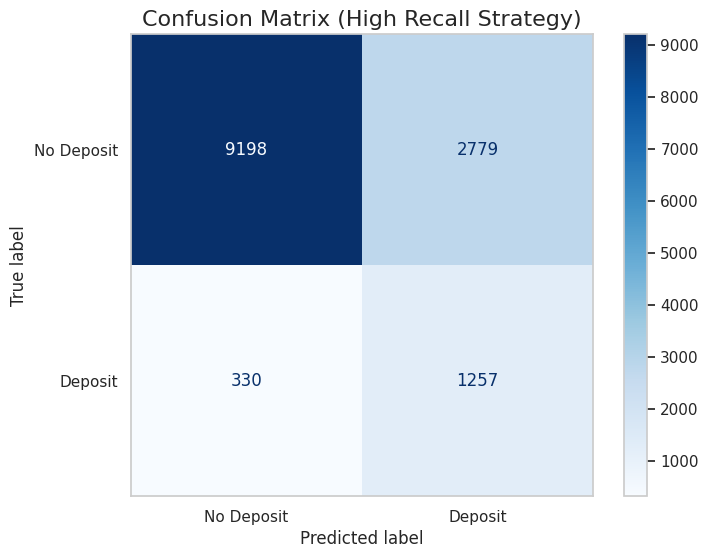


STEP 5: Visualizing Decision Tree...


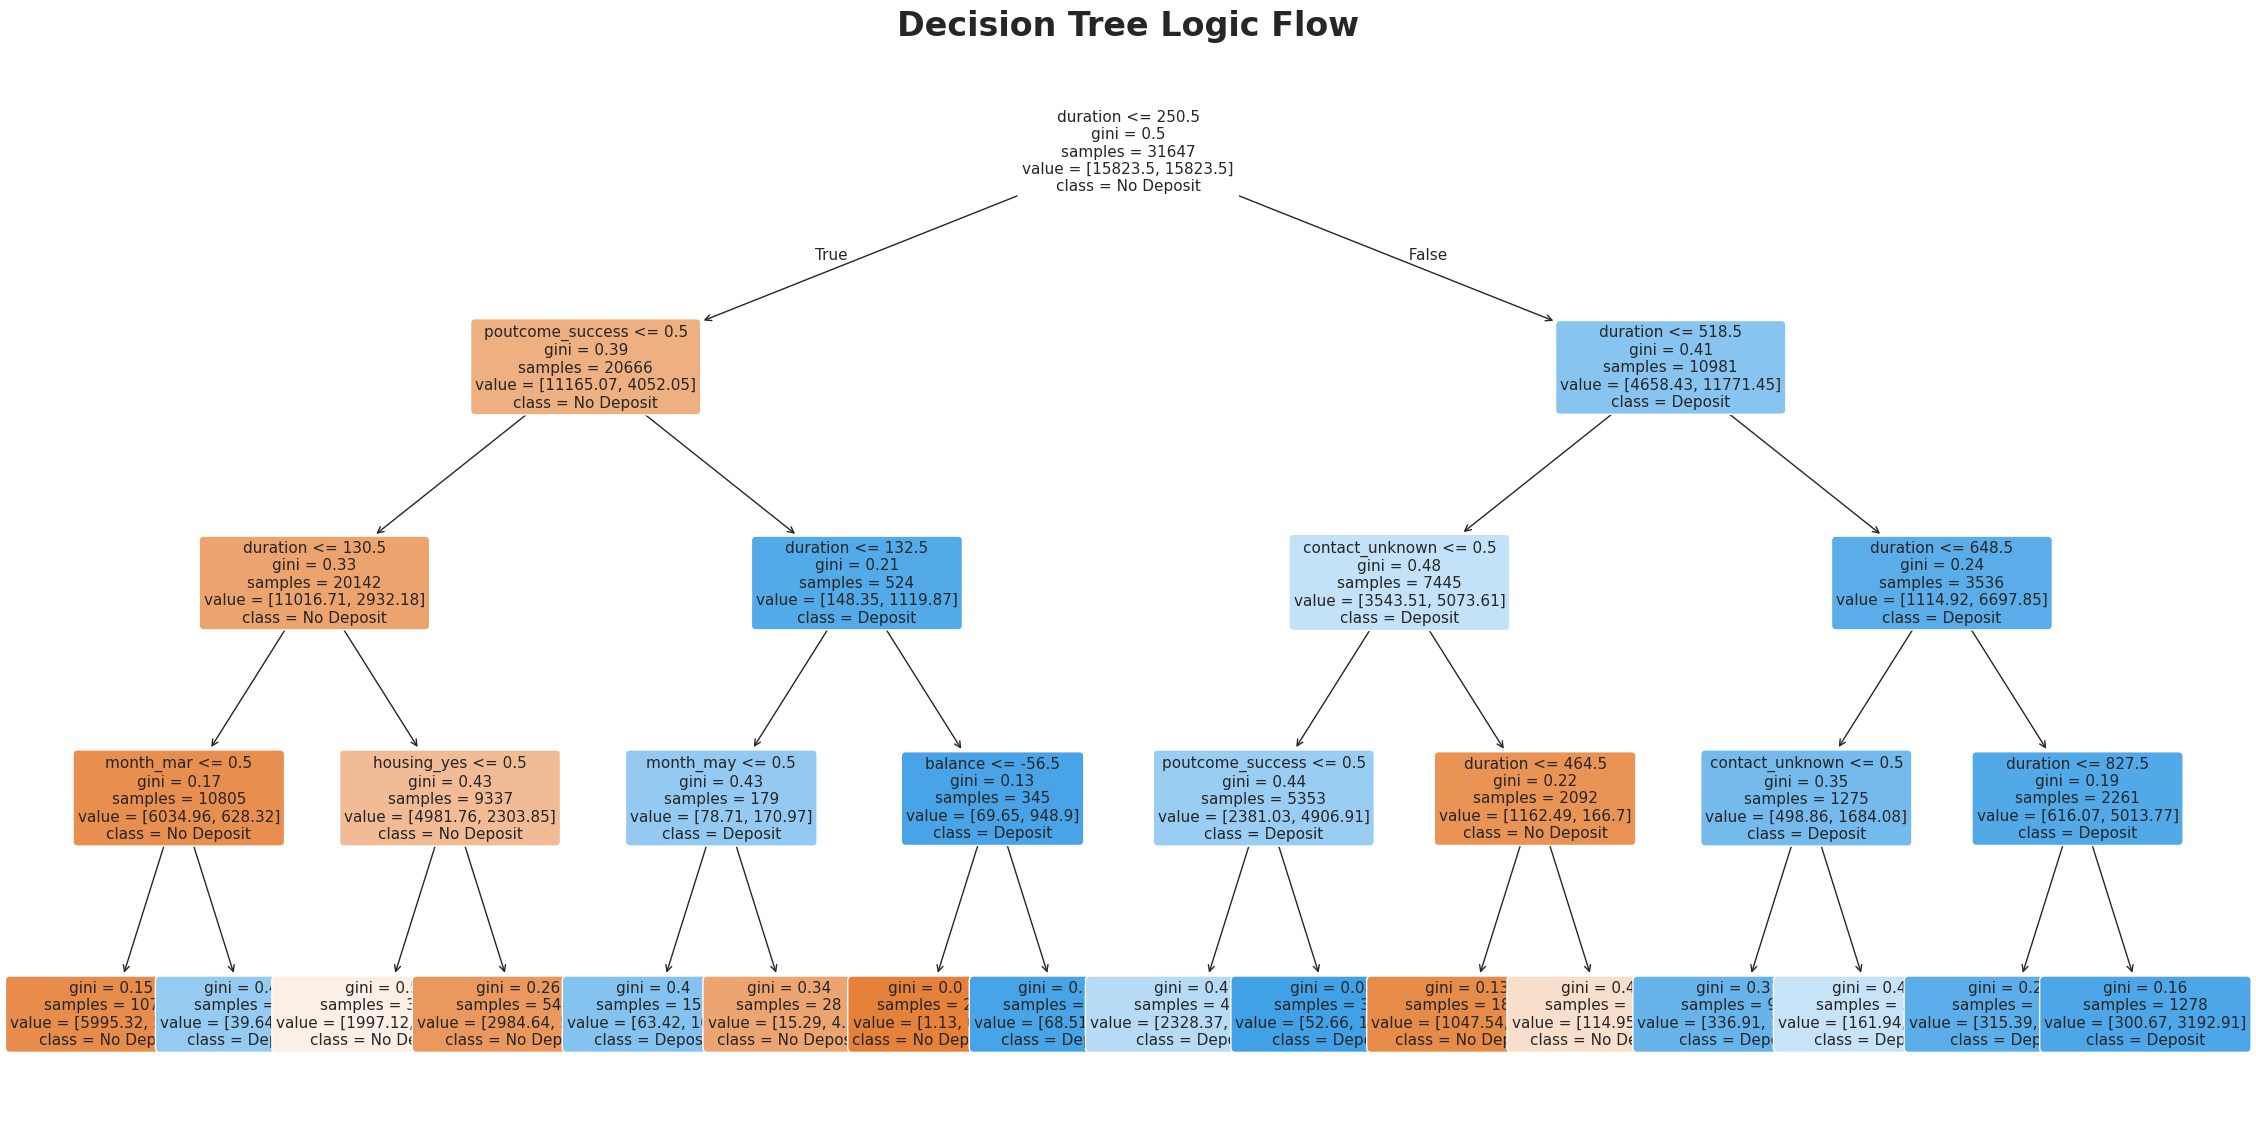


STEP 6: Extracting Key Business Rules...
|--- duration <= 250.50
|   |--- poutcome_success <= 0.50
|   |   |--- duration <= 130.50
|   |   |   |--- month_mar <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- month_mar >  0.50
|   |   |   |   |--- class: 1
|   |   |--- duration >  130.50
|   |   |   |--- housing_yes <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- housing_yes >  0.50
|   |   |   |   |--- class: 0
|   |--- poutcome_success >  0.50
|   |   |--- duration <= 132.50
|   |   |   |--- month_may <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- month_may >  0.50
|   |   |   |   |--- class: 0
|   |   |--- duration >  132.50
|   |   |   |--- balance <= -56.50
|   |   |   |   |--- class: 0
|   |   |   |--- balance >  -56.50
|   |   |   |   |--- class: 1
|--- duration >  250.50
|   |--- duration <= 518.50
|   |   |--- contact_unknown <= 0.50
|   |   |   |--- poutcome_success <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- poutcome_success >  0.50
|   |   |  

In [4]:
# TASK 8: Decision Tree – Bank Marketing Subscription Prediction (ELITE VERSION)
# Dataset: UCI Bank Marketing (via OpenML ID 1461)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# SETTING PROFESSIONAL VISUALIZATION THEME
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (24, 12)

def load_and_clean_data():
    """
    Fetches data from OpenML and renames columns to human-readable format.
    """
    print("STEP 1: Loading Dataset & Renaming Columns...")
    # Fetch data (ID 1461 is the specific 'bank-marketing' dataset)
    dataset = fetch_openml(data_id=1461, as_frame=True, parser='auto')
    df = dataset.frame

    # MAPPING DICTIONARY (V-Codes to Real Names based on UCI Documentation)
    column_mapping = {
        'V1': 'age', 'V2': 'job', 'V3': 'marital', 'V4': 'education',
        'V5': 'default', 'V6': 'balance', 'V7': 'housing', 'V8': 'loan',
        'V9': 'contact', 'V10': 'day', 'V11': 'month', 'V12': 'duration',
        'V13': 'campaign', 'V14': 'pdays', 'V15': 'previous', 'V16': 'poutcome',
        'Class': 'deposit'
    }

    # Rename columns if they match the V-pattern
    if 'V1' in df.columns:
        df = df.rename(columns=column_mapping)

    # Map target 'deposit' (1=no, 2=yes) to Binary (0, 1)
    # Note: OpenML 1461 target is '1' (No) and '2' (Yes)
    if df['deposit'].dtype == 'object' or df['deposit'].dtype.name == 'category':
        df['deposit'] = df['deposit'].apply(lambda x: 1 if x == '2' else 0)

    print(f" - Data Loaded. Shape: {df.shape}")
    print(f" - Columns: {list(df.columns)}")
    return df

def preprocess_data(df):
    """
    Encodes categorical features and prepares X/y.
    """
    print("\nSTEP 2: Preprocessing Data...")

    X = df.drop('deposit', axis=1)
    y = df['deposit']

    # Identify Categorical Columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # One-Hot Encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_encoded_array = encoder.fit_transform(X[categorical_cols])
    encoded_col_names = encoder.get_feature_names_out(categorical_cols)

    # Create DataFrame with encoded columns
    X_encoded = pd.DataFrame(X_encoded_array, columns=encoded_col_names, index=X.index)

    # Drop original cat columns and concat encoded ones
    X_numeric = X.drop(categorical_cols, axis=1)
    X_final = pd.concat([X_numeric, X_encoded], axis=1)

    print(f" - Final Feature Count: {X_final.shape[1]}")
    return X_final, y, list(X_final.columns)

def train_model(X, y):
    """
    Splits data and trains a Decision Tree with strict depth limits.
    """
    print("\nSTEP 3: Splitting & Training...")

    # Stratify is CRITICAL for imbalanced data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Training with 'balanced' weights to maximize Recall (finding subscribers)
    clf = DecisionTreeClassifier(
        criterion='gini',
        max_depth=4,
        random_state=42,
        class_weight='balanced'
    )

    clf.fit(X_train, y_train)
    print(" - Model Training Complete.")
    return clf, X_train, X_test, y_train, y_test

def evaluate_model(clf, X_test, y_test):
    """
    Generates report and Confusion Matrix.
    """
    print("\nSTEP 4: Evaluation...")

    y_pred = clf.predict(X_test)

    # Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    # Visual Confusion Matrix
    print(" - Generating Confusion Matrix...")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Deposit', 'Deposit'])

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax)
    plt.title("Confusion Matrix (High Recall Strategy)", fontsize=16)
    plt.grid(False)
    plt.show()

def visualize_tree(clf, feature_names):
    """
    Plots a High-Resolution Decision Tree.
    """
    print("\nSTEP 5: Visualizing Decision Tree...")
    plt.figure(figsize=(28, 14))

    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=['No Deposit', 'Deposit'],
        filled=True,
        rounded=True,
        fontsize=11,
        precision=2
    )
    plt.title("Decision Tree Logic Flow", fontsize=24, weight='bold')
    plt.show()

def extract_business_rules(clf, feature_names):
    """
    Extracts text-based rules for business logic.
    """
    print("\nSTEP 6: Extracting Key Business Rules...")
    # Export text representation
    tree_rules = export_text(clf, feature_names=feature_names)
    print(tree_rules[:1500])

# MAIN EXECUTION
if __name__ == "__main__":
    # 1. Load & Rename
    data = load_and_clean_data()

    # 2. Preprocess
    X_features, y_target, all_feature_names = preprocess_data(data)

    # 3. Train
    dt_model, X_train_set, X_test_set, y_train_set, y_test_set = train_model(X_features, y_target)

    # 4. Evaluate
    evaluate_model(dt_model, X_test_set, y_test_set)

    # 5. Visualize Tree
    visualize_tree(dt_model, all_feature_names)

    # 6. Extract Rules
    extract_business_rules(dt_model, all_feature_names)